In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

import pandas as pd

from my_functions import *
from LF_puricomp_corrections import weights_LF

from scipy.stats import binned_statistic

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))

In [3]:
def Zero_point_error(tile_id_Arr, catname):
    ## Load Zero Point magnitudes
    zpt_cat = pd.read_csv(f'csv/{catname}.CalibTileImage.csv', sep=',', header=1)

    zpt_mag = zpt_cat['ZPT'].to_numpy()
    zpt_err = zpt_cat['ERRZPT'].to_numpy()

    ones = np.ones((len(w_central), len(zpt_mag)))

    zpt_err = (
        mag_to_flux(ones * zpt_mag, w_central.reshape(-1, 1))
        - mag_to_flux(ones * (zpt_mag + zpt_err), w_central.reshape(-1, 1))
    )

    # Duplicate rows to match the tile_ID of each source
    idx = np.empty(tile_id_Arr.shape).astype(int)

    zpt_id = zpt_cat['TILE_ID'].to_numpy()
    for src in range(len(tile_id_Arr)):
        idx[src] = np.where(
            (zpt_id == tile_id_Arr[src]) & (zpt_cat['IS_REFERENCE_METHOD'] == 1)
        )[0][0]
    
    zpt_err = zpt_err[:, idx]

    return zpt_err

In [4]:
split_converter = lambda s: np.array(s.split()).astype(float)
sum_flags = lambda s: np.sum(np.array(s.split()).astype(float))

def load_stuff():
    pm_flx = np.array([]).reshape(60, 0)
    pm_err = np.array([]).reshape(60, 0)
    tile_id = np.array([])
    parallax_sn = np.array([])
    pmra_sn = np.array([])
    pmdec_sn = np.array([])
    starprob = np.array([])
    spCl = np.array([])
    zsp = np.array([])
    N_minijpas = 0
    for name in ['minijpas', 'jnep']:
        cat = pd.read_csv(f'csv/{name}.Flambda_aper3_photoz_gaia_3.csv', sep=',', header=1,
            converters={0: int, 1: int, 2: split_converter, 3: split_converter, 4: sum_flags,
            5: sum_flags})

        cat = cat[np.array([len(x) for x in cat['FLUX_APER_3_0']]) != 0] # Drop bad rows due to bad query
        cat = cat[(cat.FLAGS == 0) & (cat.MASK_FLAGS == 0)] # Drop flagged
        cat = cat.reset_index()

        tile_id_i = cat['TILE_ID'].to_numpy()

        parallax_i = cat['parallax'].to_numpy() / cat['parallax_error'].to_numpy()
        pmra_i = cat['pmra'].to_numpy() / cat['pmra_error'].to_numpy()
        pmdec_i = cat['pmdec'].to_numpy() / cat['pmdec_error'].to_numpy()

        pm_flx_i = np.stack(cat['FLUX_APER_3_0'].to_numpy()).T * 1e-19
        pm_err_i = np.stack(cat['FLUX_RELERR_APER_3_0'].to_numpy()).T * pm_flx_i

        if name == 'minijpas':
            N_minijpas = pm_flx_i.shape[1]

        starprob_i = cat['morph_prob_star']

        pm_err_i = (pm_err_i ** 2 + Zero_point_error(cat['TILE_ID'], name) ** 2) ** 0.5

        spCl_i = cat['spCl']
        zsp_i = cat['zsp']

        pm_flx = np.hstack((pm_flx, pm_flx_i))
        pm_err = np.hstack((pm_err, pm_err_i))
        tile_id = np.concatenate((tile_id, tile_id_i))
        pmra_sn = np.concatenate((pmra_sn, pmra_i))
        pmdec_sn = np.concatenate((pmdec_sn, pmdec_i))
        parallax_sn = np.concatenate((parallax_sn, parallax_i))
        starprob = np.concatenate((starprob, starprob_i))
        spCl = np.concatenate((spCl, spCl_i))
        zsp = np.concatenate((zsp, zsp_i))

    return pm_flx, pm_err, tile_id, pmra_sn, pmdec_sn, parallax_sn, starprob, N_minijpas,\
        spCl, zsp

pm_flx, pm_err, tile_id, pmra_sn, pmdec_sn, parallax_sn, starprob, N_minijpas,\
    spCl, zsp = load_stuff()

N_sources = pm_flx.shape[1]
is_minijpas_source = np.ones(N_sources).astype(bool)
is_minijpas_source[N_minijpas:] = False

In [5]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])

/home/alberto/cosmos/LAEs/my_functions.py:20: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


In [6]:
w_lya = 1215.67 # A

z_nb_Arr = w_central[:-4] / w_lya - 1
print(N_sources)

63923


In [7]:
pm_mask = mask_proper_motion(parallax_sn, pmra_sn, pmdec_sn)
mag_mask = (mag > 17) & (mag < 25)

mask = pm_mask & mag_mask

In [8]:
# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, 20, mask=mask)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, pm_err, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    400, obs=True, mask=mask)
other_lines = identify_lines(line_other, pm_flx, pm_err)

In [9]:
mag_min = 16
mag_max = 23.5

# Used later!!
L_min = 43.7
L_max = 50

mag_cut = (mag > mag_min) & (mag < mag_max)

z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

##
nb_min = 3
nb_max = 15

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5)/ w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5)/ w_lya - 1

z_cut = (z_min < z_Arr) & (z_Arr < z_max)

mask = z_cut & mag_cut

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr, mask=mask
)

/home/alberto/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alberto/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alberto/cosmos/LAEs/my_functions.py:504: RuntimeWarning: divide by zero encountered in double_scalars
  lya_R2_err[src] = np.sum(pm_err[l + 12 : l + 12 + 5, src] ** -2) ** -0.5
/home/alberto/cosmos/LAEs/my_functions.py:495: RuntimeWarning: divide by zero encountered in double_scalars
  lya_L_err[src] = np.sum(pm_err[l - 7 : l - 1, src] ** -2) ** -0.5


In [10]:
len(np.where(nice_lya)[0])

367

In [11]:
F_cor = np.load('npy/F_cor.npy')

In [12]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0, F_bias=F_cor
)

L_binning = np.load('npy/L_nb_err_binning.npy')
L_Lbin_err = np.load('npy/L_nb_err.npy')

# Apply bin err
L_binning_position = binned_statistic(
        10 ** L_Arr, None, 'count', bins=L_binning
).binnumber
L_binning_position[L_binning_position > len(L_binning) - 2] = len(L_binning) - 2
L_e_Arr = L_Lbin_err[L_binning_position]

# Apply L cut because of a possible Bias in caused by very badly estimated SF-LAEs
nice_lya = nice_lya & (L_Arr > L_min) & (L_Arr < L_max)

/home/alberto/cosmos/LAEs/my_functions.py:612: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_Arr = flambda / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:613: RuntimeWarning: invalid value encountered in true_divide
  EW_nb_e = flambda_e / cont / (1 + z_Arr)
/home/alberto/cosmos/LAEs/my_functions.py:631: RuntimeWarning: divide by zero encountered in log10
  L_Arr = np.log10(flambda * 4*np.pi * dL ** 2)


In [13]:
L_bins = np.load('npy/puricomp2d_L_bins.npy')
r_bins = np.load('npy/puricomp2d_r_bins.npy')
puri2d = np.load('npy/puri2d.npy')
comp2d = np.load('npy/comp2d.npy')
lyacomp = np.load('npy/lya_comp.npy')

# Selection algorithm weights
weights = weights_LF(
    L_Arr[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins, z_Arr[nice_lya],
    starprob[nice_lya], tile_id
)

/home/alberto/cosmos/LAEs/LF_puricomp_corrections.py:48: RuntimeWarning: invalid value encountered in true_divide
  w_mat = puri2d / comp2d


In [14]:
N_bins_1 = 9
N_bins_2 = 9
bins = np.concatenate((
    np.linspace(42, 43.5, N_bins_1 + 1),
    np.linspace(43.5, 45.5, N_bins_2 + 1)[1:]
))

total_hist, b = np.histogram(L_Arr[nice_lya], bins=bins)

LF_bins = np.array([(b[i] + b[i + 1]) / 2 for i in range(len(b) - 1)])

bin_width = np.array([b[i + 1] - b[i] for i in range(len(b) - 1)])

volume = z_volume(z_min, z_max, 0.895 + 0.24)
volume_mj = z_volume(z_min, z_max, 0.895)
volume_jn = z_volume(z_min, z_max, 0.24)

total_hist

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  10, 107,  65,   9,
         7,   3,   0,   1,   0])

In [15]:
## Let's compute the error contribution due to L uncertainty as in Spinoso2020:
# Perturbing the L with its error and computing 1000 Luminosity functions with
# the result.

def LF_perturb_err(L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob,
    bins, which_w=[0, 2]):
    N_bins = len(bins) - 1

    N_iter = 200
    hist_i_mat = np.zeros((N_iter, N_bins))

    for k in range(N_iter):
        L_perturbed = np.log10(
            10 ** L_Arr + L_e_Arr * np.random.randn(len(L_e_Arr))
        )
        L_perturbed[np.isnan(L_perturbed)] = 0.

        w = weights_LF(
            L_perturbed[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins,
            z_Arr[nice_lya], starprob[nice_lya], tile_id, which_w
        )
        hist = np.histogram(L_perturbed[nice_lya], bins=bins)[0]
        hist_poiss_err = np.round(
            hist[0] ** 0.5 * np.random.randn(len(bins) - 1), 0
        ).astype(int)

        hist_binnumber = binned_statistic(L_perturbed[nice_lya], None, 'count', bins=bins)[2]

        L_Arr_to_hist = np.array([])
        w_Arr_to_hist = np.array([])
        for bin in range(N_bins):
            where_bin = np.where(hist_binnumber == bin + 1)[0]
            try:
                idx = np.random.choice(
                    where_bin, size=(hist_poiss_err[bin] + hist[bin]),
                    replace=True
                )
                L_Arr_to_hist = np.hstack([L_Arr_to_hist, L_perturbed[nice_lya][idx]])
                w_Arr_to_hist = np.hstack([w_Arr_to_hist, w[idx]])
            except:
                pass
        hist_i_mat[k], _ = np.histogram(L_Arr_to_hist, bins=bins, weights=w_Arr_to_hist)

    L_LF_err_percentiles = np.percentile(hist_i_mat, [16, 50, 84], axis=0)
    return L_LF_err_percentiles

L_LF_err_percentiles = LF_perturb_err(
    L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob, bins
)
L_LF_err_plus = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median = L_LF_err_percentiles[1]

L_LF_err_percentiles = LF_perturb_err(
    L_Arr[is_minijpas_source], L_e_Arr[is_minijpas_source], nice_lya[is_minijpas_source],
    mag[is_minijpas_source], z_Arr[is_minijpas_source], starprob[is_minijpas_source],
    bins
)
L_LF_err_plus_mj = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus_mj = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median_mj = L_LF_err_percentiles[1]

L_LF_err_percentiles = LF_perturb_err(
    L_Arr[~is_minijpas_source], L_e_Arr[~is_minijpas_source], nice_lya[~is_minijpas_source],
    mag[~is_minijpas_source], z_Arr[~is_minijpas_source], starprob[~is_minijpas_source],
    bins
)
L_LF_err_plus_jn = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus_jn = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median_jn = L_LF_err_percentiles[1]

/tmp/ipykernel_573092/1412933393.py:13: RuntimeWarning: invalid value encountered in log10
  L_perturbed = np.log10(


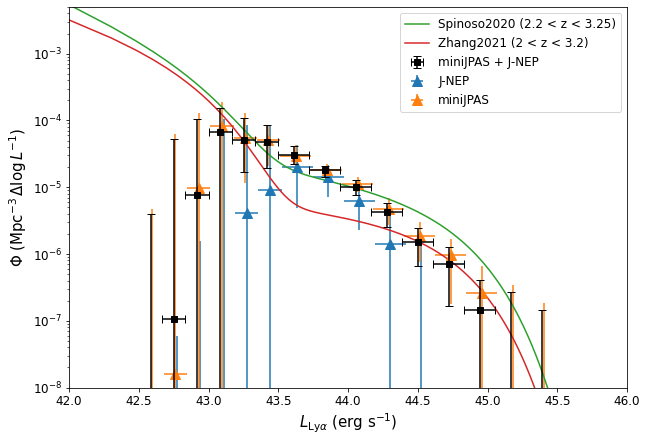

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins, hist_median / volume / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='s', linestyle='', color='k', capsize=4,
    label='miniJPAS + J-NEP', zorder=99)

yerr_cor_plus = (hist_median_jn + L_LF_err_plus_jn ** 2) ** 0.5\
     / volume_jn / bin_width
yerr_cor_minus = (hist_median_jn + L_LF_err_minus_jn ** 2) ** 0.5\
     / volume_jn / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins + 0.024, hist_median_jn / volume_jn / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='^', linestyle='', markersize=10, label='J-NEP')

yerr_cor_plus = (hist_median_mj + L_LF_err_plus_mj ** 2) ** 0.5\
     / volume_mj / bin_width
yerr_cor_minus = (hist_median_mj + L_LF_err_minus_mj ** 2) ** 0.5\
     / volume_mj / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins + 0.012, hist_median_mj / volume_mj / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='^', linestyle='', markersize=10, label='miniJPAS')

Lx = np.linspace(10 ** 42, 10 ** 46, 10000)
phistar1 = 3.33e-6
Lstar1 = 44.65
alpha1 = -1.35

phistar2 = -3.45
Lstar2 = 42.93
alpha2 = -1.93

Phi_center = double_schechter(
     Lx, phistar1, 10 ** Lstar1, alpha1, 10 ** phistar2, 10 ** Lstar2, alpha2
) * Lx * np.log(10)

ax.plot(np.log10(Lx), Phi_center, label='Spinoso2020 (2.2 < z < 3.25)')

Lx = np.linspace(10 ** 42, 10 ** 46, 10000)
phistar1 = 10 ** -3.41
Lstar1 = 10 ** 42.87
alpha1 = -1.7

phistar2 = 10 ** -5.85
Lstar2 = 10 ** 44.6
alpha2 = -1.2

Phi_center = double_schechter(
     Lx, phistar1, Lstar1, alpha1, phistar2, Lstar2, alpha2
) * Lx * np.log(10)

ax.plot(np.log10(Lx), Phi_center, label='Zhang2021 (2 < z < 3.2)')

ax.set_yscale('log')
ax.set_xlabel(r'$L_{\mathrm{Ly}\alpha}$ (erg s$^{-1}$)', fontsize=15)
ax.set_ylabel(r'$\Phi$ (Mpc$^{-3}\,\Delta\logL^{-1}$)',
    fontsize=15)
ax.set_ylim(1e-8, 5e-3)
ax.set_xlim(42, 46)
ax.legend(fontsize=12)

plt.show()

In [17]:
print(total_hist)
print(hist_median)
print(np.sum(hist_median))

[  0   0   0   0   0   0   0   0   0  10 107  65   9   7   3   0   1   0]
[  0.           0.           0.           0.           0.28800633
  20.12809358 181.02213335 135.80718578 127.47063415 109.59102784
  63.35060456  36.37000221  14.87905451   5.32890583   2.5218276
   0.51612903   0.           0.        ]
697.2736047787222


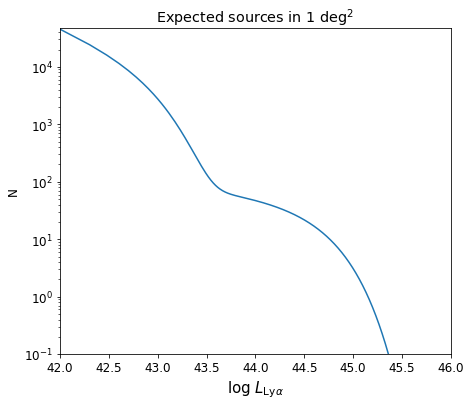

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(np.log10(Lx), Phi_center * z_volume(z_min, z_max, 1))

ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.set_ylabel('N')

ax.set_title('Expected sources in 1 deg$^2$')

ax.set_xlim((42, 46))
ax.set_ylim((1e-1, None))

ax.set_yscale('log')

plt.show()

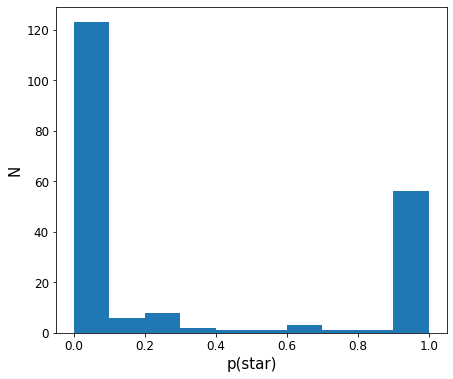

In [19]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.hist(starprob[nice_lya], 10)

ax.set_xlabel('p(star)', fontsize=15)
ax.set_ylabel('N', fontsize=15)

plt.show()

202 candidates
38 QSO (18 w/ right z)
3 GALAXY (0 w/ right z)
160 No SDSS counterpart


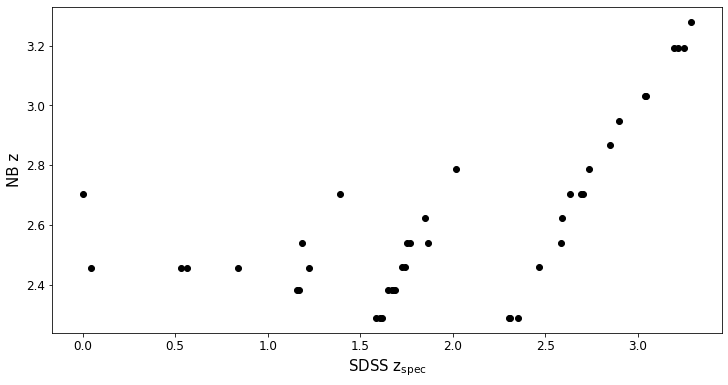

In [20]:
nice_z = (np.abs(z_Arr - zsp) < 0.12)

print('{} candidates'.format(count_true(nice_lya)))
print('{} QSO ({} w/ right z)'.format(count_true(spCl[nice_lya] == 'QSO'), count_true((spCl[nice_lya] == 'QSO') & nice_z[nice_lya])))
print('{} GALAXY ({} w/ right z)'.format(count_true(spCl[nice_lya] == 'GALAXY'), count_true((spCl[nice_lya] == 'GALAXY') & nice_z[nice_lya])))
print('{} No SDSS counterpart'.format(count_true(spCl[nice_lya].astype(str) == 'nan')))

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(zsp[nice_lya], z_Arr[nice_lya], c='k')

ax.set_xlabel('SDSS z$_\mathrm{spec}$', fontsize=15)
ax.set_ylabel('NB z', fontsize=15)

plt.show()

In [21]:
# perc_total = LF_perturb_err(
#     L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob, bins, L_binning, which_w=[]
# )[1]
# perc_0 = LF_perturb_err(
#     L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob, bins, L_binning, which_w=[0]
# )[1]
# perc_1 = LF_perturb_err(
#     L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob, bins, L_binning, which_w=[2]
# )[1]
# perc_012 = LF_perturb_err(
#     L_Arr, L_e_Arr, nice_lya, mag, z_Arr, starprob, bins, L_binning, which_w=[0, 2]
# )[1]

In [22]:
# fig, ax = plt.subplots(figsize=(7, 6))

# ax.plot(LF_bins, perc_0 / perc_total, ls='--', label='Detection puri/comp')
# ax.plot(LF_bins, perc_1 / perc_total, ls='--', label='r completeness curve')
# # ax.plot(LF_bins, perc_2 / perc_total, ls='--', label='r completeness curve')
# ax.plot(LF_bins, perc_012 / perc_total, c='k', label='Total correction factor')
# ax.hlines(1, 42, 46, color='dimgray', linewidth=1, ls='dotted')

# ax.set_xlim((42.63, 44.9))
# # ax.set_ylim((0, 3))

# ax.legend(fontsize=12, loc=1)

# plt.show()